# Test `seatracker` Module

This is a development notebook used as an integration test as code
is ported from Susan's original `SeaTracker.ipynb` implementation
into the `seatracker.py` module.

In [1]:
from itertools import product
import math
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import netCDF4 as nc
import numpy as np
from scipy.integrate import ode
from scipy.interpolate import LinearNDInterpolator

import seatracker

In [2]:
%matplotlib inline

* Staggered grids : Done
* Multiple points : Done
* tmask : Done (or at least fake one done)
* off depth and onto grid (done)
* e1t etc (sketched)
* the surface (badly done)

In [3]:
# Set up run: test points are not on the walls
def test_points(t_coords, u_coords, v_coords, w_coords, tmask, yi):
    testpoint = np.zeros((4))
    for point in range(yi.shape[0]):
        testpoint[1:] = yi[point]
        testpoint[0] = t_coords[0, 0]
        velocity = interpolator(t_mask, e3w, e2v, e1u, w_coords, v_coords, u_coords, w, v, u, testpoint)
        if np.all(velocity == [0, 0, 0]):
            t_mask[int(testpoint[1]), int(testpoint[2]), int(testpoint[3])] = 0
            print (int(testpoint[1]), int(testpoint[2]), int(testpoint[3]), 'zerod')
    return t_mask

In [4]:
def myplotter(ax, t0, y0, npoints, cmap, yc, initial=False):
    ct = 20.
    if initial:
        for ip in range(npoints):
            ax[1, 0].plot(t0, -y0[ip, 0], 'ko')
            ax[0, 0].plot(t0, y0[ip, 1], 'ks')
            ax[0, 1].plot(t0, y0[ip, 2], 'k^')
            ax[2, 0].plot(y0[ip, 2], y0[ip, 1], 'bx')
            ax[2, 1].plot(y0[ip, 2], y0[ip, 1], 'bx')
            ax[1, 1].scatter(y0[ip, 2], y0[ip, 1], -y0[ip, 0], c='k')
    else:
        for ip in range(npoints):
            ax[1, 0].plot(t0, -y0[ip, 0], 'bo')
            ax[0, 0].scatter(t0, y0[ip, 1], color=cmap((y0[ip, 0]-yc+ct)/(2*ct)))
            ax[0, 1].scatter(t0, y0[ip, 2], color=cmap((y0[ip, 0]-yc+ct)/(2*ct)))
            ax[2, 0].scatter(y0[ip, 2], y0[ip, 1], color=cmap((y0[ip, 0]-yc+ct)/(2*ct)))
            ax[2, 1].scatter(y0[ip, 2], y0[ip, 1], color=cmap((y0[ip, 0]-yc+ct)/(2*ct)))
            ax[1, 1].scatter(y0[ip, 2], y0[ip, 1], -y0[ip, 0], c='b')

In [5]:
def foo(mesh_mask_path, u_field_path, v_field_path, w_field_path, tracer_fields_path):
    # set up graphing
    cmap = mpl.cm.get_cmap('plasma_r')
    fig, ax = plt.subplots(3, 2)
    fig.clf()
    fig = plt.figure(figsize=(15, 20))
    ax[0, 0] = fig.add_subplot(3, 2, 1)
    ax[0, 1] = fig.add_subplot(3, 2, 2)
    ax[1, 0] = fig.add_subplot(3, 2, 3)
    ax[1, 1] = fig.add_subplot(3, 2, 4, projection='3d')
    ax[2, 0] = fig.add_subplot(3, 2, 5)
    ax[2, 1] = fig.add_subplot(3, 2, 6)

    # get initial data
    t_mask, e1u, e2v, e3w0, totaldepth, fractiondepth = seatracker.initialize_mesh(mesh_mask_path)
    (u, v, w, tcorrs, t_coords, u_coords, v_coords, 
     w_coords, deltat, nextindex, e3w, udataset, vdataset, wdataset, tdataset) = seatracker.get_initial_data(
        u_field_path, v_field_path, w_field_path, tracer_fields_path, fractiondepth, totaldepth, e3w0)
    # get a new point
    tc, yi = seatracker.random_points(t_coords, deltat, t_mask)
#     tc, yi = seatracker.grid_points(t_coords, t_mask, 25-1, 446-1, 304-1)

    ax[2, 0].pcolormesh(np.arange(398) - 0.5, np.arange(898) - 0.5, t_mask[0], cmap='Greys_r')
    ax[2, 0].set_xlim(t_coords[3, 0], t_coords[3, -1])
    ax[2, 0].set_ylim(t_coords[2, 0], t_coords[2, -1])

    ax[2, 1].pcolormesh(np.arange(398) - 0.5, np.arange(898) - 0.5, t_mask[0], cmap='Greys_r')
    size = 40

    ax[2, 1].set_xlim(yi[0, 2]-size, yi[0, 2]+size)
    ax[2, 1].set_ylim(yi[0, 1]-size, yi[0, 1]+size)

    ax[0, 0].set_xlim(tcorrs[0], tcorrs[0]+24.5*deltat)
    ax[0, 1].set_xlim(tcorrs[0], tcorrs[0]+24.5*deltat)


    # set up values for integrator
    t0 = tcorrs[0]
    dt = deltat/10.
    npoints = yi.shape[0]
    y0 = np.copy(yi)
    yp = np.ndarray.flatten(y0)

    # plot initial points
    myplotter(ax, t0, y0, npoints, cmap, y0[0, 0], initial=True)

    # initialize integrator    
    myintegrator = ode(seatracker.derivatives).set_integrator('dopri5', atol=0.01) # https://www.mathworks.com/help/matlab/ref/ode45.html
    myintegrator.set_initial_value(yp, t0).set_f_params(t_mask, e3w, e2v, e1u, 
                                                        w_coords, v_coords, u_coords, w, v, u)

    # first segment
    t1 = t0 + 1.5*deltat

    while myintegrator.successful() and myintegrator.t < t1:
        myintegrator.integrate(myintegrator.t + dt)
        myplotter(ax, myintegrator.t, np.reshape(myintegrator.y, (npoints, 3)), npoints, cmap, y0[0, 0])

    # and the rest
    for count in range(1):
        # update arrays
        tcorrs, u_coords, v_coords, w_coords, u, v, w, nextindex, e3w = seatracker.update_arrays(
            totaldepth, fractiondepth, e3w0, e3w, tcorrs, u_coords, v_coords, w_coords, u, v, w, 
            deltat, nextindex, udataset, vdataset, wdataset, tdataset)
        print(nextindex)
        t1 += deltat

        while myintegrator.successful() and myintegrator.t < t1:
            myintegrator.integrate(myintegrator.t + dt)
            myplotter(ax, myintegrator.t, np.reshape(myintegrator.y, (npoints, 3)), npoints, cmap, y0[0, 0])

/home/doug/Documents/MOAD/seatracker-python/seatracker.py:49: RuntimeWarning: divide by zero encountered in true_divide
  fractiondepth = gdepw_0 / totaldepth
/home/doug/Documents/MOAD/seatracker-python/seatracker.py:49: RuntimeWarning: invalid value encountered in true_divide
  fractiondepth = gdepw_0 / totaldepth


4
50.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


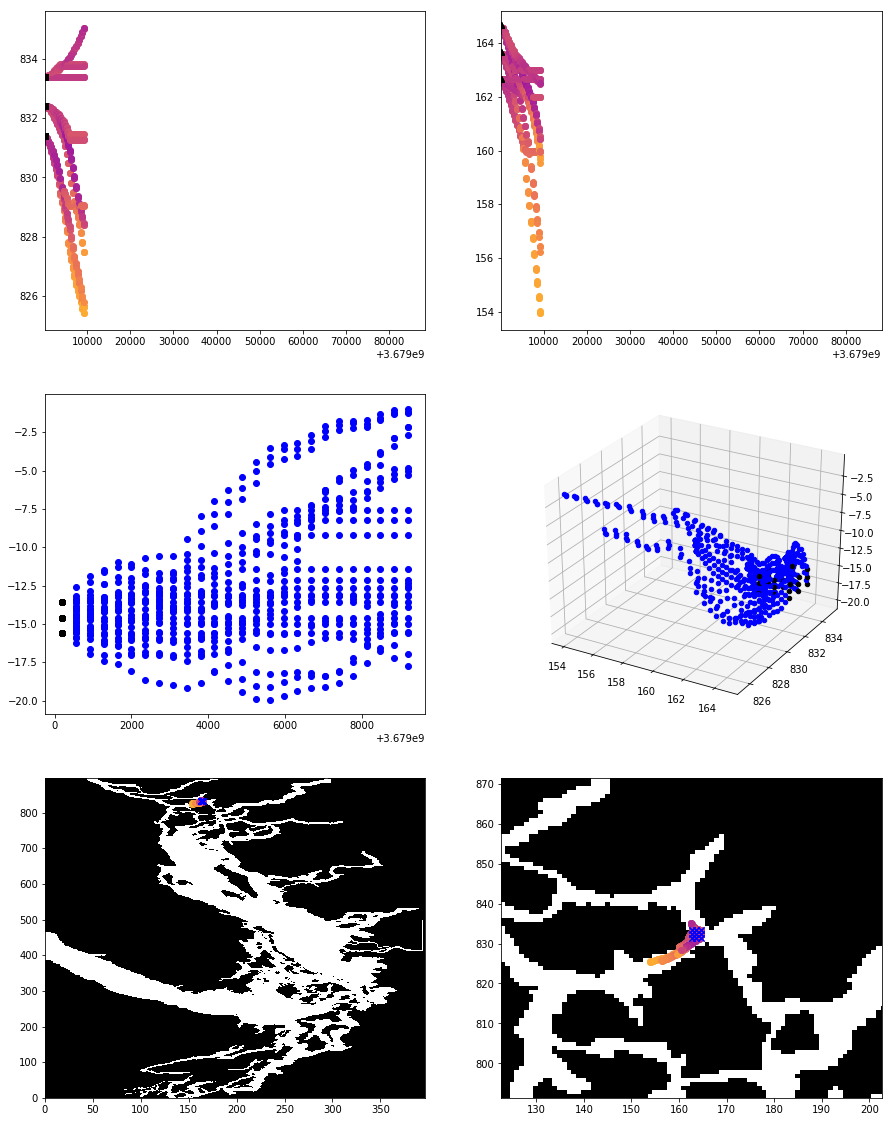

In [6]:
%%timeit -n1 -r1

from importlib import reload
reload(seatracker)

mesh_mask_path = '../../MEOPAR/grid/mesh_mask201702.nc'
u_field_path = 'hindcast/SalishSea_1h_20160801_20160801_grid_U.nc'
v_field_path = 'hindcast/SalishSea_1h_20160801_20160801_grid_V.nc'
w_field_path = 'hindcast/SalishSea_1h_20160801_20160801_grid_W.nc'
tracer_fields_path = 'hindcast/SalishSea_1h_20160801_20160801_grid_T.nc'

foo(mesh_mask_path, u_field_path, v_field_path, w_field_path, tracer_fields_path)